# Importação das bibliotecas

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
from keras import models, regularizers, layers, optimizers, losses, metrics
tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0'

# Carregamento da base de dados

Fontes da base de dados:
- https://www.sirm.org/category/senza-categoria/covid-19/
- https://github.com/ieee8023/covid-chestxray-dataset
- https://towardsdatascience.com/detecting-covid-19-induced-pneumonia-from-chest-x-rays-with-transfer-learning-an-implementation-311484e6afc1

Preparação de bases para medicina
- https://medium.com/@hbjenssen/covid-19-radiology-data-collection-and-preparation-for-artificial-intelligence-4ecece97bb5b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/covidnormal1.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [ ]:
image = tf.keras.preprocessing.image.load_img(r'/content/covidnormal1/train/Covid/01.jpeg', target_size=(224,224))

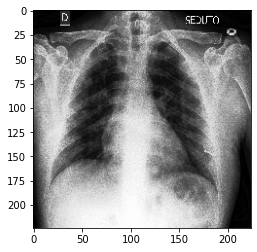

In [ ]:
plt.imshow(image);

train_datagen tranforma as imagens no formato para o tensor flow e o imagedatagenerator gera novas imagens apartir das q tem só que com filtros, ou rotacionadas.

está utlizando tranferencia de aprendizagem da rede neural já treinada resnet50

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, 
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/covidnormal1/train/',
                                                    target_size = (224, 224),
                                                    batch_size=16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 160 images belonging to 2 classes.


batch_size de quantos registro vai fazer a atualização de pesos, vai calcular o erros e acerto de 16 imagens e ai atualiza os pesos
class_mode trabalho de classificação de categorical
sshuffle = true irá pegar as imagens em aleartório
isso na classe de treino



In [ ]:
train_generator.n

160

In [ ]:
train_generator.batch_size

16

In [ ]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

10

// para dá valores inteiros, base de teste tesar cm as imagens originias e não com as modificadas, estão sendo criadas novas imagens pra treino no caso o train_datagen só no treino e não teste.

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
test_generator = test_datagen.flow_from_directory('/content/covidnormal1/test',
                                                  target_size=(224,244),
                                                  batch_size=1,
                                                  class_mode = 'categorical',
                                                  shuffle = True)

Found 46 images belonging to 2 classes.


In [ ]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

46

# Transfer learning

etapas da cnn:
etapa 1: operador de convolução(relu)detecto de caracteristicas é colocar filtros no operador de convolucao da rede, geralmente cada tipo de rede tem seu filtro, mapa de caracteristica é a nova imagem criada após a convolução e assim vc reduz as dimensões da imagem, ignorando as bordas.

função de ativação no mapa de caracteristicas
relu< 0 retorna 0 
relu>0 retorna o proprio valor

etapa 2: POOLING
pega o mapa de caracteristica e aplica uma formula
maxpolling = pega o valor maximo de uma seleção ex: filtro 2x2 pega o maior pixel e passa pra nova no mapa e gera uma nova imagem diminundo mais a sua dimensão.
nas features na cnn indica quuantos mapas de caracteristica  diferentes vc quer da imagem, quantos filtros e após será feito o max polling de todas os mapas gerados de cada mapa.


etapa 3 : flattening

tranforma as matrizes em vetores para passar na rede neural
etapa 4 :

rede neural com as camadas de entrada, escondida e saída. Com saída sigmoid q significa q o resultado ou é um ou outro e a probrabilidade de acerto de q é aquilo msm.

se vc trabalha com mais de 2 classe vc usa a função de ativação diferente a função softmax, no caso de só 2 classes é usado o sigmoid 
transfer learning = 

## Construção do modelo

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

include_top= false pois n vai carregar a aparte q a resnet faz efetivamente classificação dos objetos, mas apenas a sua parte convolucional. 

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
x = base_model.output

x vai receber a ultima camada da rede com output, da rede sem editar o cabeçalho de como a gente quer.

globalavaregepolling retirar uma media global e diminuir as dimensões dos dados, essa função tem q vim sempre apóes uma variavel receber a ultima camada da rede pra fazer uma ligação cm essa variavel nesse caso x.

camadas densas: 1024 neuronios, função relu e ligar com a camada global q liga cm a ultima da saida da resnet.
são 3 camadas densas, ultima 512 neurnios
preds recebe como parametro o numero de classes, nesse caso 2 e a função de de ativação softmax retorna a problabilidade de cada classes.

model cria a rede a rede neural completa, acima só ligou as camadas.
model ( rede que entra a resnet e a saida em preds)





In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='sigmoid')(x)



In [ ]:
model = tf.keras.Model(inputs = base_model.input, outputs = preds)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

# Esse processo se chama congelamento( FINE-TUNNING): congela modelo base e descongela  a parte personalizada.os for abaixo indica que as camadas até 174 irão usar os pesos do imagenet  que já estão prontos e 175 que foi criado pra baixo com as camadas densas, parte nova da rede neural irá treinar para atualizar as partes novas.

In [ ]:
for i, layer in enumerate(model.layers[:175]):
  layer.trainable = False  
  print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
for i, layer in enumerate(model.layers[175:]):
  layer.trainable = True
  print(i, layer.name)  

0 global_average_pooling2d_1
1 dense_12
2 dense_13
3 dense_14
4 dense_15


In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

O compilamento vai receber o otimizador adam, função de erro crossentropy e métrica só a acurácia. A variável history é o treinamento, fit_generator foi colcoado pq acima usou o imagedaatagenerator e no paramento indica onde esse gerador foi usado que foi na pasta de treino armazena nessa variavel aí, ephocas ,steps_perepoch recebe as normalizações acima as divisões da quantidade de imagens pelos bacht size isso da pasta treino, e  o validation recebe da pasta teste.

326 filas, cada 1 com 16 registros na base de treinamento.

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=20,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

Epoch 1/20
10/10 [==============================] - 13s 1s/step - loss: 0.9761 - accuracy: 0.7688 - val_loss: 0.2536 - val_accuracy: 0.9348
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.1924 - accuracy: 0.9500 - val_loss: 0.1299 - val_accuracy: 0.9565
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.1614 - accuracy: 0.9250 - val_loss: 0.7854 - val_accuracy: 0.7609
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 0.2698 - accuracy: 0.9125 - val_loss: 0.2692 - val_accuracy: 0.8478
Epoch 5/20
10/10 [==============================] - 12s 1s/step - loss: 0.1593 - accuracy: 0.9500 - val_loss: 0.0817 - val_accuracy: 0.9565
Epoch 6/20
10/10 [==============================] - 12s 1s/step - loss: 0.0558 - accuracy: 0.9812 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 12s 1s/step - loss: 0.0285 - accuracy: 0.9937 - val_loss: 0.1053 - val_accuracy: 0.9565
Epoch 8/20
10/10 [==

In [ ]:
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")
print(model.summary())

model compiled
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
________________________________________________________________________

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=20,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

Epoch 1/20
10/10 [==============================] - 13s 1s/step - loss: 0.7277 - accuracy: 0.7875 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.1581 - accuracy: 0.9375 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.0974 - accuracy: 0.9688 - val_loss: 0.0226 - val_accuracy: 0.9783
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.1469 - accuracy: 0.9625 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.0481 - accuracy: 0.9875 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.0457 - accuracy: 0.9750 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.0727 - accuracy: 0.9688 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 8/20
10/10 [==

# Avaliação

## Gráficos

In [ ]:
np.mean(history.history['val_accuracy'])

0.9989130437374115

In [ ]:
np.std(history.history['val_accuracy'])

0.0047379325046719364

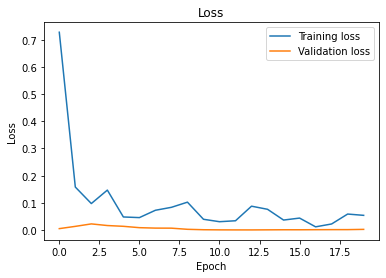

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

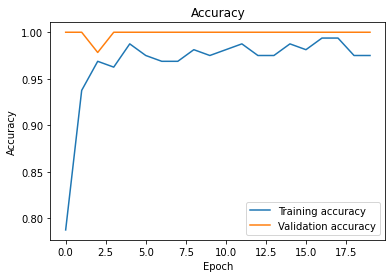

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

## Previsões

In [ ]:
filenames = test_generator.filenames
filenames

['Covid/0100.jpeg',
 'Covid/0102.jpeg',
 'Covid/0105.png',
 'Covid/0106.jpeg',
 'Covid/0108.jpeg',
 'Covid/0111.jpg',
 'Covid/0112.jpg',
 'Covid/0113.jpg',
 'Covid/0115.jpeg',
 'Covid/0118.jpeg',
 'Covid/0119.jpeg',
 'Covid/0120.jpg',
 'Covid/094.png',
 'Covid/096.png',
 'Covid/098.jpeg',
 'Covid/COVID-00003b.jpg',
 'Covid/COVID-00012.jpg',
 'Covid/COVID-00022.jpg',
 'Covid/COVID-00033.jpg',
 'Covid/COVID-00037.jpg',
 'Covid/auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg',
 'Covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'Covid/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'Covid/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'Covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'Covid/radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg',
 'Normal/0101.jpeg',
 'Normal/0102.jpeg',
 'Normal/0103.jpeg',
 'Normal/0105.jpeg',
 'Normal/0106.jpeg',
 'N

In [ ]:
len(filenames)

46

In [ ]:
predictions = model.predict_generator(test_generator, steps = len(filenames))

In [ ]:
predictions

array([[1.0000000e+00, 1.7507078e-08],
       [9.9998307e-01, 2.0103565e-05],
       [9.9789751e-01, 2.0924539e-03],
       [9.9999988e-01, 7.5366010e-08],
       [2.3918676e-03, 9.9765402e-01],
       [1.4181498e-03, 9.9849904e-01],
       [6.1448134e-04, 9.9943334e-01],
       [9.9994409e-01, 5.4669974e-05],
       [9.9996722e-01, 3.2877786e-05],
       [2.1111753e-02, 9.8157030e-01],
       [9.9999094e-01, 8.6943937e-06],
       [1.4269378e-03, 9.9852729e-01],
       [1.6055959e-03, 9.9824822e-01],
       [1.0000000e+00, 8.5186098e-09],
       [9.9999905e-01, 1.2103180e-06],
       [9.9996150e-01, 4.0533381e-05],
       [3.6250390e-02, 9.6911871e-01],
       [9.9991226e-01, 1.0487287e-04],
       [2.1515388e-02, 9.7944939e-01],
       [1.0000000e+00, 1.6573313e-08],
       [9.9985433e-01, 1.5118472e-04],
       [9.9999571e-01, 5.0502399e-06],
       [9.9997377e-01, 2.9361365e-05],
       [9.9998677e-01, 1.4407214e-05],
       [6.2971069e-03, 9.9356079e-01],
       [9.9979967e-01, 2.

In [ ]:
len(predictions)

46

percorree cada resgistro e pegar o indice que detem o maior valor por exexmplo , argmax vai retornar os indices q contém os maiores valores.
: o item de um registro ter 100% de certeza q é da classe 0 e 4 % de q é da classe 1

In [ ]:
predictions2 = []
for i in range(len(predictions)):
  #print(predictions[i])
  predictions2.append(np.argmax(predictions[i]))

In [ ]:
predictions2

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0]

agora comparar os dados do predictionda prediçao com os da basereal com .classes para indicar cada 1 das classes.e o algortimo acertou todos os registros. class_indices mostra quais classes e indices que são.

In [ ]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [ ]:
test_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(predictions2, test_generator.classes)

0.6086956521739131

acurracy_score recebe as predições e os valores reais da classes

In [ ]:
cm = confusion_matrix(predictions2, test_generator.classes)
cm

array([[17,  9],
       [ 9, 11]])

primeiro é os acerto,erros


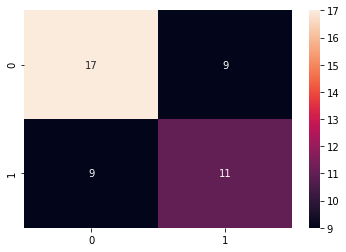

In [ ]:
sns.heatmap(cm, annot=True);

## Teste com imagem

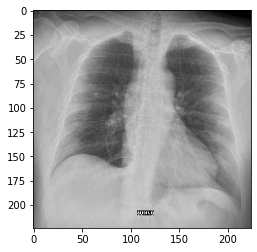

In [ ]:
image = tf.keras.preprocessing.image.load_img(r'/content/covidnormal1/train/Covid/010.png', target_size=(224,224))
plt.imshow(image);

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

In [ ]:
type(image)

numpy.ndarray

In [ ]:
np.max(image), np.min(image)

(255.0, 0.0)

In [ ]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

np.expand_dims coloca a imagem pra receber o parametro bacthsize junto com a dimensão da imagem e o numero de canais, esstá 1 porque ele tá testando com 1 imagem pra validar 

In [ ]:
image = tf.keras.applications.resnet50.preprocess_input(image)

In [ ]:
np.max(image), np.min(image)

(151.061, -123.68)

In [ ]:
predictions = model.predict(image)
print(predictions)

[[1.0000000e+00 3.0832727e-08]]


In [ ]:
predictions[0]

array([1.0000000e+00, 3.0832727e-08], dtype=float32)

In [ ]:
np.argmax(predictions[0])

0

In [ ]:
list(train_generator.class_indices)

['Covid', 'Normal']

In [ ]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'Covid'

Utilizando a U-net para segmentação

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from skimage.io import imread
from skimage.transform import resize

In [ ]:
path = "/content/database.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [ ]:
database_classes = glob('database/*/')
n_classes = len(database_classes)
n_files = glob('database/*/*.tif')

labels = np.zeros((len(n_files),n_classes))
images = np.zeros((len(n_files),100,100,3))

cont = 0
lb = 0
for classes in database_classes:
    files_in_classe = glob(classes+'*.tif')
    for fc in files_in_classe:
        labels[cont,lb] = 1
        im = imread(fc)
        image_resized = resize(im, (100,100,3))
        images[cont,:,:,:] = image_resized
        cont+=1
    lb +=1

In [ ]:
labels.shape

(200, 2)

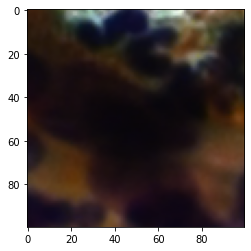

In [ ]:
plt.imshow(images[50,:,:])

In [ ]:
from sklearn.model_selection import train_test_split
import keras
import time
from glob import glob
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
#Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from keras import backend as K
from keras import optimizers


In [ ]:
print('Tamanho do Treino: ', X_train.shape)
print('Tamanho do Teste: ', X_validation.shape)

Tamanho do Treino:  (140, 100, 100, 3)
Tamanho do Teste:  (60, 100, 100, 3)


In [ ]:
def get_crop_shape(target, refer):
        cw = (target.get_shape()[2] - refer.get_shape()[2])
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1])
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)
    
def get_unet(n_ch,patch_height,patch_width):
    concat_axis = 3

    inputs = Input((patch_height, patch_width, n_ch))
    
    conv1 = Conv2D(32, (3, 3), padding="same", name="conv1_1", activation="relu", data_format="channels_last")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv5)

    up_conv5 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv4)
    up6   = concatenate([up_conv5, crop_conv4], axis=concat_axis)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv6)

    up_conv6 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv3)
    up7   = concatenate([up_conv6, crop_conv3], axis=concat_axis)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv7)

    up_conv7 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv2)
    up8   = concatenate([up_conv7, crop_conv2], axis=concat_axis)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv8)

    up_conv8 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv1)
    up9   = concatenate([up_conv8, crop_conv1], axis=concat_axis)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv9)

    #ch, cw = get_crop_shape(inputs, conv9)
    #conv9  = ZeroPadding2D(padding=(ch[0],cw[0]), data_format="channels_last")(conv9)
    #conv10 = Conv2D(1, (1, 1), data_format="channels_last", activation="sigmoid")(conv9)
    
    flatten =  Flatten()(conv9)
    Dense1 = Dense(512, activation='relu')(flatten)
    BN =BatchNormalization() (Dense1)
    Dense2 = Dense(2, activation='sigmoid')(BN)
    
    model = Model(inputs=inputs, outputs=Dense2)
    #Model(inputs=modelVGG.input, outputs=predictions)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy']
    )
    
    return model

In [ ]:
batch_size = 10
nb_epoch = 15
steps_per_epoch = X_train.shape[0]//batch_size
validation_steps = X_validation.shape[0]//batch_size

In [ ]:

X_train, X_validation, Y_train, Y_validation = train_test_split(images, labels, test_size = 0.3)



model = get_unet(3, 100, 100)

train_generator = ImageDataGenerator().flow(
        X_train,
        Y_train,
        batch_size=batch_size
)

validation_generator = ImageDataGenerator().flow(
        X_train,
        Y_train,
        batch_size=batch_size
)

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epoch, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True)

results = model.predict_generator(X_validation,30,verbose=1)

print(results)



Epoch 1/15
14/14 [==============================] - 1s 60ms/step - loss: 0.3584 - accuracy: 0.8214 - val_loss: 0.6947 - val_accuracy: 0.6000
Epoch 2/15
14/14 [==============================] - 1s 42ms/step - loss: 0.2415 - accuracy: 0.9357 - val_loss: 0.6367 - val_accuracy: 0.5333
Epoch 3/15
14/14 [==============================] - 1s 42ms/step - loss: 0.1198 - accuracy: 0.9286 - val_loss: 0.7285 - val_accuracy: 0.4333
Epoch 4/15
14/14 [==============================] - 1s 43ms/step - loss: 0.1339 - accuracy: 0.9357 - val_loss: 0.4675 - val_accuracy: 0.7167
Epoch 5/15
14/14 [==============================] - 1s 43ms/step - loss: 0.1232 - accuracy: 0.9500 - val_loss: 0.2815 - val_accuracy: 0.9667
Epoch 6/15
14/14 [==============================] - 1s 43ms/step - loss: 0.1007 - accuracy: 0.9643 - val_loss: 0.2238 - val_accuracy: 0.9833
Epoch 7/15
14/14 [==============================] - 1s 42ms/step - loss: 0.0976 - accuracy: 0.9714 - val_loss: 0.3711 - val_accuracy: 0.8500
Epoch 8/15
14

In [ ]:
model.evaluate(X_validation, Y_validation, verbose=1)

2/2 [==============================] - 0s 123ms/step - loss: 0.2542 - accuracy: 0.8667


[0.2541768550872803, 0.8666666746139526]

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_validation, verbose=1)

2/2 [==============================] - 0s 17ms/step


In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
  def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(X[ix, ..., 0], cmap='seismic')
    ax.set_title('Seismic')

    

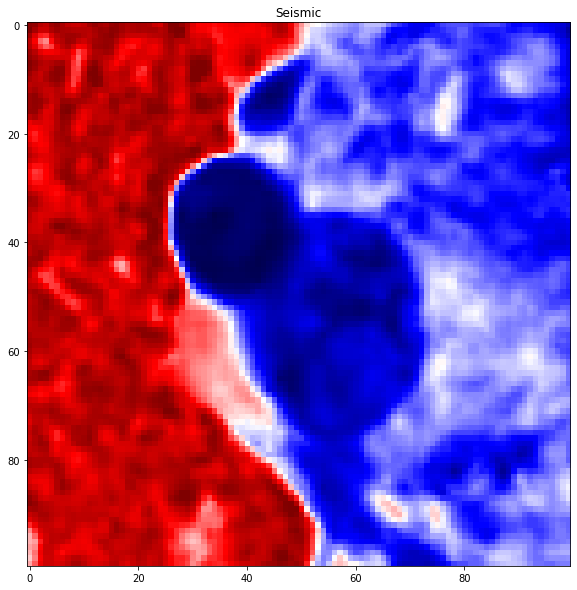

In [ ]:
plot_sample(X_validation, Y_validation, preds_val, preds_val_t, ix=3)